# Estudio de los datos de Ventas de una Ferretería

Autor: Diana Chacón Ocariz

## Contexto:

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).


## Objetivos del negocio:

**Tener más visibilidad sobre las ventas para poder mejorar el proceso de compras y la toma de decisiones en general:** 

    - Poder analizar objetivamente las ventas
    - Determinar los productos que podrían entrar en rotura de stock al final de un período
    - Identificar los productos menos vendidos
    - Identificar patrones en el comportamiento de las ventas para poder hacer predicciones de ventas
    

## Objetivos académicos:

    - Estudiar un caso real, con datos reales y cuyo resultado pueda ayudar a alguien a resolver un problema 
    - Demostrar que la ciencia de datos también puede ayudar a las PYMES
    - Conocer y practicar el uso de herramientas de ciencia de datos
    
## Fuentes de datos:

Los datos provienen de reportes sacados del software de gestión de la empresa. Se trata de archivos .xls que contienen sólo los datos de reportes sobre ventas por producto (2021 y 2022) y el stock al final del período. También se utiliza el histórico de la tasa de cambio del dólar para hacer el análisis en base a montos en esta moneda y paliar los problemas de inflación.

# Notebook 2: EDA

Recuperamos los datos (ya limpios) de los archivos **parquet** para comenzar un análisis más profundo de los datos, responder preguntas del negocio, verificar si hay patrones en las ventas y preparar los datos para utilizarlos en modelos predictivos

In [2]:
# Librerías utilizadas

import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import altair as alt

In [3]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

In [4]:
%%time 
df_ventas = pd.read_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", engine='fastparquet')
df_ventas

CPU times: user 3.76 s, sys: 128 ms, total: 3.89 s
Wall time: 4.33 s


,num,fecha_comp,cliente,vendedor,cod,producto,cantidad,monto,tipo,fecha,tasa_dolar,monto_dolar
0,0000000702,2021-01-21 10:02:00,18637949,14,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,2.0,5.40,fa,2021-01-21,1.787455,3.021055
1,0000000703,2021-01-21 10:24:00,19339285,7,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,2.70,fa,2021-01-21,1.787455,1.510527
2,0000000701,2021-01-21 09:56:00,13175393,13,00010,"LLAVE 1/2"" ESFERICA BRONCE PALANCA GRINACA COL...",1.0,9.52,fa,2021-01-21,1.787455,5.326008
3,0000000706,2021-01-21 10:37:00,5852700,7,00018,LAPICERO BIC,1.0,0.47,fa,2021-01-21,1.787455,0.262944
4,0000000689,2021-01-21 09:30:00,17220345,7,00028,TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E,1.0,0.65,fa,2021-01-21,1.787455,0.363645
...,...,...,...,...,...,...,...,...,...,...,...,...
28920,0000006814,2022-01-20 15:06:00,14281231.0,3,06108,TOMA DOBLE POLARIZADO MARFIL 15A 125V VERT JEH...,1.0,7.28,ne,2022-01-20,4.810000,1.513514
28921,0000006827,2022-01-20 16:29:00,9204926.0,13,06196,"ABRAZADERA METALICA 3/8"" 6MM-13MM",3.0,13.08,ne,2022-01-20,4.810000,2.719335
28922,0000006820,2022-01-20 15:45:00,14583939.0,14,06300,"CURVA 3/4"" NEGRA POLIETILENO ELECTRICIDAD ECON...",2.0,1.46,ne,2022-01-20,4.810000,0.303534
28923,0000006787,2022-01-20 09:58:00,10749538.0,13,06306,"REGADOR 1/2"" MINI WLOBBER MINI BAILARINA DIAME...",1.0,8.05,ne,2022-01-20,4.810000,1.673597


In [5]:
%%time 
df_stock = pd.read_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", engine='fastparquet')
df_stock

CPU times: user 13.2 ms, sys: 123 µs, total: 13.3 ms
Wall time: 12.7 ms


,cod,producto,categoria,stock,fecha
0,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,GENERALES,16.5,2022-02-01
1,00002,MANTO ASFALTICO 10MTSx3.2MM BITUPLAST,NO ASIGNADO,3.0,2022-02-01
2,00003,"TACO 1"" BASE REDONDA PVC DURA PARA PATAS DE MU...",GENERALES,13.0,2022-02-01
3,00004,MUEBLE ACCESORIOS DE BAÑO HIERRO FORJADO(UNIDAD),HIERRO FORJADO JC Y ABRAZADERAS METALICAS RIEGO,2.0,2022-02-01
4,00005,"NIPLE PLASTICO 1"" * 13CMS","NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",34.0,2022-02-01
...,...,...,...,...,...
3546,06381,MAXICAL 10 KILOS,GENERALES,45.0,2022-02-01
3547,06382,CONFITERIA CARAMELO CHAO X2,CHUCHERIAS,280.0,2022-02-01
3548,06383,CONFITERIA TRIDENT TOTAL YERBABUENA,CHUCHERIAS,4.0,2022-02-01
3549,06384,HIDROJET DE ALTA PRESION 1400W INGCO,GENERALES,1.0,2022-02-01


# Patrones en las ventas

In [37]:
df_ventas['mes_anio'] = df_ventas.fecha.dt.strftime('%m-%Y')

df_ventas_fecha = df_ventas.pivot_table(index='mes_anio', values=['num', 'cantidad', 'monto_dolar'], 
                                        aggfunc={'num':'count', 'cantidad':sum, 'monto_dolar':sum })
df_ventas_fecha

,cantidad,monto_dolar,num
mes_anio,,,
01-2021,11736.19,14713.510895,2643
01-2022,9328.27,22459.938157,2342
02-2021,8693.29,15435.559011,2293
02-2022,58.00,113.795493,17
03-2021,10569.95,12893.195983,2176
04-2021,8232.41,12754.088586,1893
05-2021,6588.22,13513.743208,1581
06-2021,8598.50,14145.454537,1920
07-2021,11890.17,18510.729686,2657


<AxesSubplot:xlabel='mes_anio'>

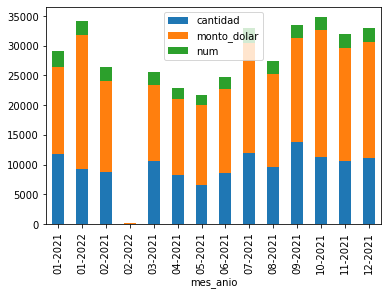

In [43]:
df_ventas_fecha.plot.bar(stacked=True)

In [44]:
df_ventas_fecha.reset_index(inplace=True)

In [67]:
# Definición de los colores para los gráficos
TITULOS = '#17407b'
MONTO = '#99e265' #'#5ebc0d'
VOLUMEN = '#2649e8'  #'#17407b'
FACTURAS = '#fff952' #'#efea46'

# Ejes 
x = alt.X('mes_anio:O', title='Mes y Año', axis = alt.Axis(labelAngle=90, labelFontSize=12))
y1 = alt.Y('monto_dolar:Q', title = '')
y2 = alt.Y('cantidad:Q', title = '')
y3 = alt.Y('num:Q', title = '')


base = alt.Chart(df_ventas_fecha).encode(x=x)

monto = base.mark_bar(color=MONTO, cornerRadiusTopLeft=3, cornerRadiusTopRight=3).encode(y=y1,
                tooltip = [alt.Tooltip('mes_anio', title='Mes y año'), 
                   alt.Tooltip('monto_dolar', title='Ventas en $')])

volumen = base.mark_bar(color=VOLUMEN).encode(y=y2,
                tooltip = [alt.Tooltip('mes_anio', title='Mes y año'),  
                   alt.Tooltip('cantidad', title='Volumen de Ventas')])
                                             
facturas = base.mark_bar(color=FACTURAS,).encode(y=y3,
                tooltip = [alt.Tooltip('mes_anio', title='Mes y año'), 
                   alt.Tooltip('num', title='N° de Facturas')])

textos1 = base.mark_text().encode(
    text = alt.Text(y1, format=',.5s', title = 'Ventas en $'),
)

grafico = alt.layer(monto, volumen, facturas)

grafico.properties(
        title='Ventas en $ - Volúmenes de Ventas - N° de Facturas',
        width=800
).configure_title(
    fontSize = 16,
    anchor = 'middle',
    color = TITULOS,
).configure_view(
    strokeWidth=1
)

alt.LayerChart(...)

In [23]:
# Se trata de un gráfico de capas
# https://altair-viz.github.io/user_guide/compound_charts.html

# Definimos la selección para hacer el gráfico interactivo
# Cuando el mouse se acerca a la línea de un país, 
# esta aumenta de grosor
highlight = alt.selection(type='single', on='mouseover',
                          fields=['country'], nearest=True)


base = alt.Chart(df_ventas_fecha).mark_line().encode(
    x = alt.X('year:O', title='', axis = alt.Axis(labelAngle=0, labelFontSize=12)),
    y = alt.Y('life_expect:Q', title = 'Esperanza de vida', scale=alt.Scale(zero=False), 
              axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
    color = alt.Color('country:N', scale=alt.Scale(domain=paises, range=colores)), 
    tooltip = [alt.Tooltip('country', title='País'), 
               alt.Tooltip('life_expect', title='Esperanza de vida'), 
               alt.Tooltip('year', title='Año')]
)


# opacity=alt.value(0.5) permite que se muestren los puntos 
# opacity=alt.value(0) muestra líneas contínuas 
points = base.mark_circle().encode(
    opacity=alt.value(0.5)
).add_selection(
    highlight
).properties(
    title = f"Esperanza de vida en {mis_paises} de 1955 a 2005",
    width=600
)

# Permite cambiar el aspecto de las líneas cuando el ratón se acerca
# Se utiliza la negación de la selección ~highlight para evitar
# que el gráfico tenga las líneas resaltadas al cargar
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

# Para los gráficos multicapas, pueden utilizarse
# cualquiera de las 2 sintaxis (+ y alt.layer)

#points + lines

grafico = alt.layer(
  points,
  lines
).interactive()

grafico



heatmap = alt.Chart(source).mark_rect().encode(
    alt.X('IMDB_Rating:Q', bin=True),
    alt.Y('Rotten_Tomatoes_Rating:Q', bin=True),
    alt.Color('count()', scale=alt.Scale(scheme='greenblue'))
)

points = alt.Chart(source).mark_circle(
    color='black',
    size=5,
).encode(
    x='IMDB_Rating:Q',
    y='Rotten_Tomatoes_Rating:Q',
)

heatmap + points


base = alt.Chart(source).encode(x='year:O')

bar = base.mark_bar().encode(y='wheat:Q')

line =  base.mark_line(color='red').encode(
    y='wages:Q'
)

(bar + line).properties(width=600)

fecha
2021-01-05    609.40
2021-01-06    335.98
2021-01-07    305.85
2021-01-08    264.00
2021-01-09    154.00
               ...  
2022-01-28     49.00
2022-01-29     12.00
2022-01-31     15.00
2022-02-01     35.00
2022-02-02     23.00
Name: cantidad, Length: 323, dtype: float64

In [9]:
df_ventas_fecha['Dia'] = df_ventas_fecha.fecha.dt.weekday
df_ventas_fecha['Mes'] = df_ventas_fecha.fecha.dt.month
df_ventas_fecha['Año'] = df_ventas_fecha.fecha.dt.year
df_ventas_fecha

AttributeError: 'DatetimeProperties' object has no attribute 'WeekOfMonth'

In [6]:
df_ventas_semana = df_ventas.pivot_table()

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)